# Tarea 1 - Ciencia de Datos
### Por: Gustavo Hernández Angeles

## Preparación

In [ ]:
import numpy as np
from ucimlrepo import fetch_ucirepo 
from time import perf_counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from sklearn.cluster import AgglomerativeClustering

In [93]:
def distancia_minkowski(x, y, p):
    """
    Distancia de Minkowski de orden p.
    
    Parámetros
    ----------
    x : np.ndarray
    y : np.ndarray
    p : float
    
    Devuelve
    --------
    distancia : float
    """
    return np.sum(np.abs(x-y)**p)**(1/p)

def jerarquico_aglomerativo(X : np.ndarray, n_clusters : int, umbral : float = None, 
                            enlace = "single-linkage", p = 2):
    """
    Clustering Jerárquico Aglomerativo.
    -----------------------------------
    
    Calcula los clusters mediante el Clusterin Jerárquico Aglomerativo.  
    Se implementa la distancia de Minkowski de orden p.
    
    Parámetros
    ----------
    ``X`` : np.ndarray 
        Matriz de datos.
    ``n_clusters`` : int 
        Número de clusters.
    ``umbral`` : float 
        Umbral de distancia para detener el algoritmo.
    ``enlace`` : str 
        Tipo de enlace. Puede ser "single-linkage", "complete-linkage" o "average-linkage".
    ``p`` : float 
        Orden de la distancia de Minkowski.
        
    Devuelve
    --------
    ``label`` : ndarray tamaño (n_samples,)
        El label[i] representa el indice del cluster al que pertenece
        la i-esima observación
    """
    
    
    n = X.shape[0]
    
    # Cada punto es un cluster
    clusters = [[i] for i in range(n)]
    
    # Inicializar matriz de disimilitud
    matriz_disim = np.array([[distancia_minkowski(X[i], X[j], p) 
                              for j in range(n)] 
                             for i in range(n)])
    
    
    # Hacer hasta obtener n_clusters clusters
    for t in range(n-n_clusters):
        
        # Encontrar los clusters más cercanos
        minimo = np.inf
        for i in range(n-t):
            for j in range(n-t):
                if i != j and matriz_disim[i,j] < minimo:
                    minimo = matriz_disim[i,j]
                    min_i = i
                    min_j = j
        
        # Detenerse si la distancia menor es menor al umbral
        if umbral is not None and minimo > umbral:
            break
        
        clusters[min_i] += clusters[min_j]
        clusters.pop(min_j)
        
        # Distancias segun enlace
        if enlace == "single-linkage":
            # Distancia mínima del cluster ij al resto de clusters
            distancias_nuevoCluster = np.array([min(matriz_disim[min_i,k], matriz_disim[min_j,k]) 
                                                for k in range(n-t)
                                                if k != min_i and k != min_j])
            distancias_nuevoCluster = np.insert(distancias_nuevoCluster, min_i, 0)
        elif enlace == "complete-linkage":
            # Distancia maxima del cluster ij al resto de clusters
            distancias_nuevoCluster = np.array([max(matriz_disim[min_i,k], matriz_disim[min_j,k])
                                                for k in range(n-t)
                                                if k != min_i and k != min_j])
            distancias_nuevoCluster = np.insert(distancias_nuevoCluster, min_i, 0)
        elif enlace == "average-linkage":
            distancias_nuevoCluster = np.zeros(n-t)
            n_ij = len(clusters[min_i])
            for cluster_k in clusters[:min_i] + clusters[min_i+1:]:
                n_k = len(cluster_k)
                indice_k = clusters.index(cluster_k)
                for vector_k in cluster_k:
                    for vector_ij in clusters[min_i]:
                        # d_{ij,k} = \sum_{i \in C_{ij}} \sum_{k \in C_k} d_{ik}
                        distancias_nuevoCluster[indice_k] += distancia_minkowski(vector_k, vector_ij, p)
                distancias_nuevoCluster[indice_k] /= n_ij * n_k
        
        # Actualizar matriz de disimilaridad
        matriz_disim = np.delete(matriz_disim, min_j, axis = 0)
        matriz_disim = np.delete(matriz_disim, min_j, axis = 1)
        matriz_disim[min_i] = distancias_nuevoCluster
        matriz_disim[:,min_i] = distancias_nuevoCluster
    
    # Devolver etiquetas
    labels = np.full(n,-1)
    for i in range(n_clusters):
        for indice in clusters[i]:
            labels[indice] = i
    
    return labels
    
    
def k_medias(X : np.ndarray, n_clusters : int, max_iter = 100, tol = 1e-4, p = 2):
    """
    Algoritmo K-means
    -----------------
    
    Clustering mediante el algoritmo K-means.  
    Se implementa la distancia de Minkowski de orden p.
    
    Parámetros
    ----------
    ``X`` : np.ndarray 
        Matriz de datos.
    ``n_clusters`` : int 
        Número de clusters.
    ``max_iter`` : int 
        Número máximo de iteraciones.
    ``tol`` : float 
        Convergencia del algoritmo.
    ``p`` : float 
        Orden de la distancia de Minkowski.
        
    Devuelve
    --------
    ``centroides`` : ndarray (n_clusters, n_features)

    ``label`` : ndarray tamaño (n_samples,)
        El label[i] representa el indice del centroide más cercano 
        a la i-esima observación
    """
    n = X.shape[0]
    labels = np.zeros(n)
    
    # Se proponen clusters
    centroides = X[np.random.choice(n, n_clusters, replace = False)]
    centroides_pasados = None
    
    for i in range(max_iter):
        
        # Condicion de convergencia
        if centroides_pasados is not None:
            # Calculamos la norma de la diferencia entre los centroides actuales y los anteriores
            diferencias = [distancia_minkowski(centroides[i], centroides_pasados[i], p) 
                           for i in range(n_clusters)]
            if max(diferencias) < tol:
                break
        
        # Inicializar clusters
        clusters = [[] for _ in range(n_clusters)]
        
        # Rellenar clusters
        for i in range(n):
            c_i = np.argmin([distancia_minkowski(X[i], centroide, p)**p 
                             for centroide in centroides])
            clusters[c_i].append(X[i])
            labels[i] = c_i
            
        
        # Guardar centroides actuales   
        centroides_pasados = centroides.copy()
        
        # Actualizar centroides como la media de sus puntos
        for j in range(n_clusters):
            
            # Si está vacío el cluster, no se actualiza
            if not clusters[j]:
                continue
            
            centroides[j] = np.mean(clusters[j], axis = 0)
    
                
    
    return (centroides, labels)


def coeficiente_silueta(X, labels, p=2):
    """
    Silueta promedio de un clustering.
    -----------------------------------
    
    Calcula el coeficiente de silueta promedio de un clustering.  
    Se implementa la distancia de Minkowski de orden p.

    Parámetros
    ----------
    ``clusters`` : list 
        Lista de clusters, cada cluster (lista) contiene los puntos que le pertenecen.
    ``p`` : float 
        Orden de la distancia de Minkowski.
        
    Devuelve
    --------
    ``s_k_promedio``: float 
        Coeficiente de silueta promedio.
    """
    # Numero de clusters y de puntos
    n_clusters = len(set(labels))
    n = X.shape[0]
    
    clusters = [[X[i] for i in range(n) if label == labels[i]] for label in range(n_clusters)]
        
    # Inicializar s_k en ceros
    s_k = np.zeros(n_clusters)
    
    # Iteramos sobre los clusters
    for k in range(n_clusters):
        vectores_k = clusters[k]
        
        # Ignoramos un cluster si está vacío
        if len(vectores_k) == 0:
            continue
        
        # Iteramos sobre cada vector del cluster
        for vector in vectores_k:
            # Calcular a_i
            a_i = np.mean([distancia_minkowski(vector, vector_k, p)
                           for vector_k in vectores_k
                           if not np.array_equal(vector, vector_k)])
            
            # Calcular b_ic (tamaño k-1) y obtener b_i
            b_ic = [np.mean([distancia_minkowski(vector, vector_c, p)
                                for vector_c in clusters[c]])
                            for c in range(n_clusters) if c != k]
            b_i = min(b_ic)
            
            s_i = (b_i - a_i) / max(a_i, b_i)
            s_k[k] += s_i
    
    # Regresamos el promedio de todas las s_i
    s_k_promedio = s_k.sum() / n
    return s_k_promedio

In [94]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = iris.data.features
y = iris.data.targets

In [95]:
df = pd.concat([X,y], axis = 1)
df

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


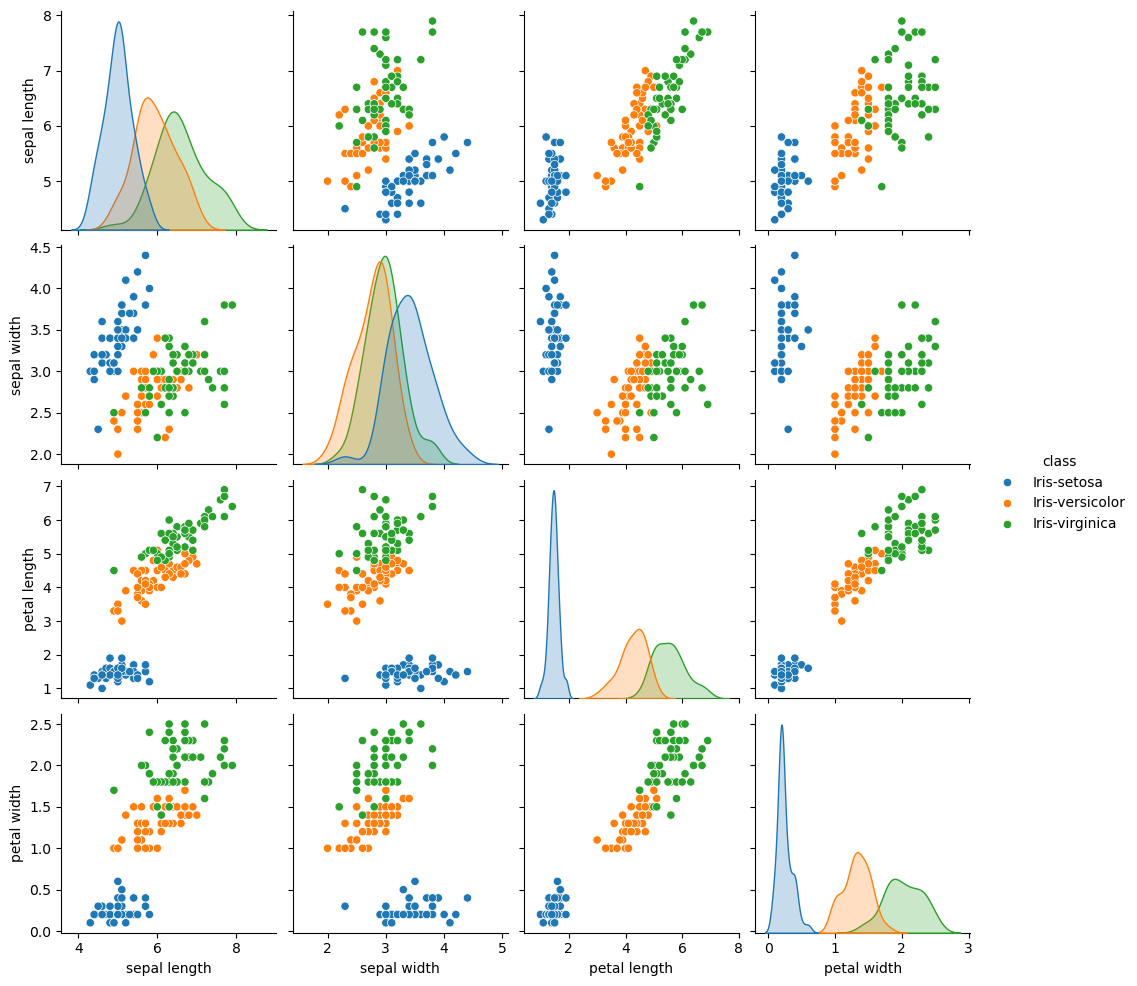

In [96]:
sns.pairplot(df, hue="class")

In [97]:
kmedias = k_medias(X.to_numpy(), 3)
clases = pd.DataFrame({'class' : kmedias[1]})
df_mio = pd.concat([X, clases], axis = 1)

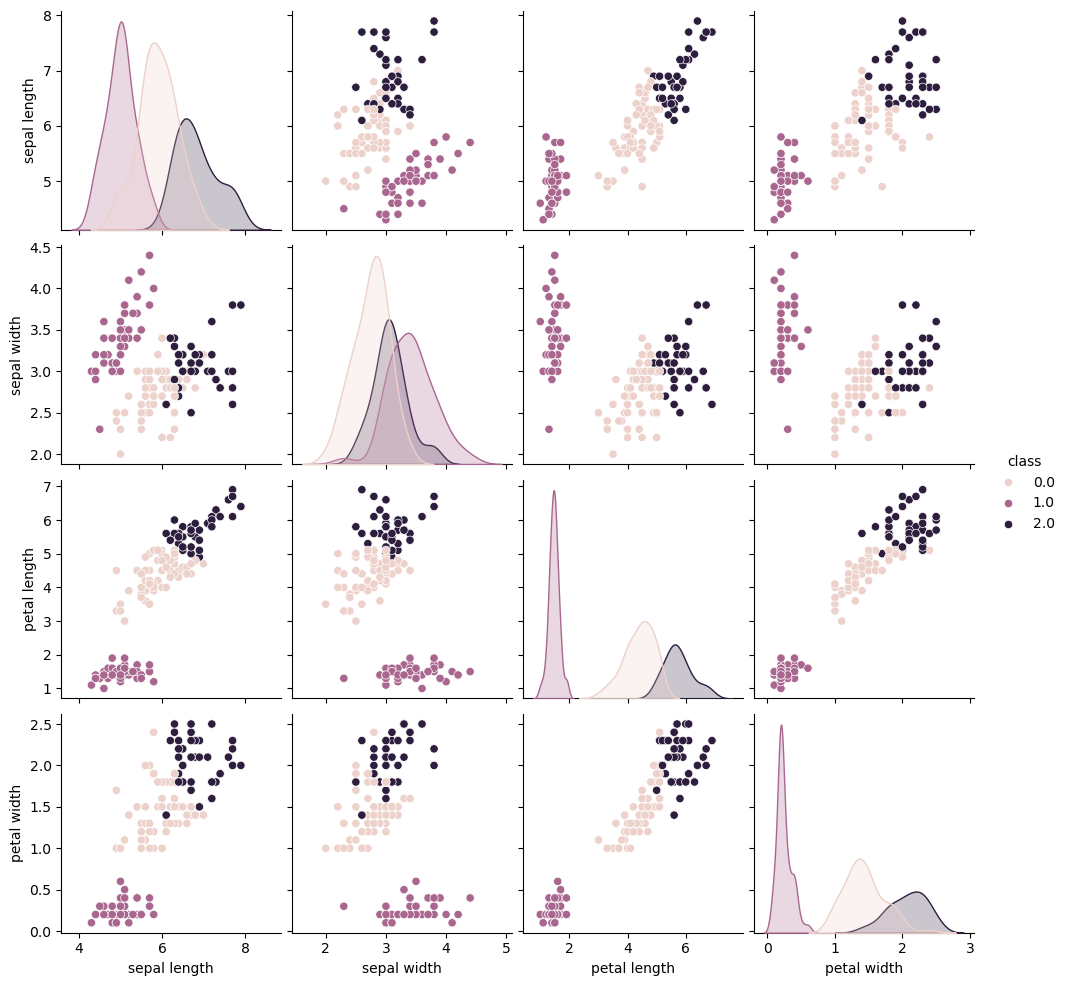

In [98]:
sns.pairplot(df_mio, hue="class")

In [99]:
jerarquico = jerarquico_aglomerativo(X.to_numpy(), n_clusters=3)
clases = pd.DataFrame({"class" : jerarquico})
df_jerarquico = pd.concat([X,clases], axis=1)

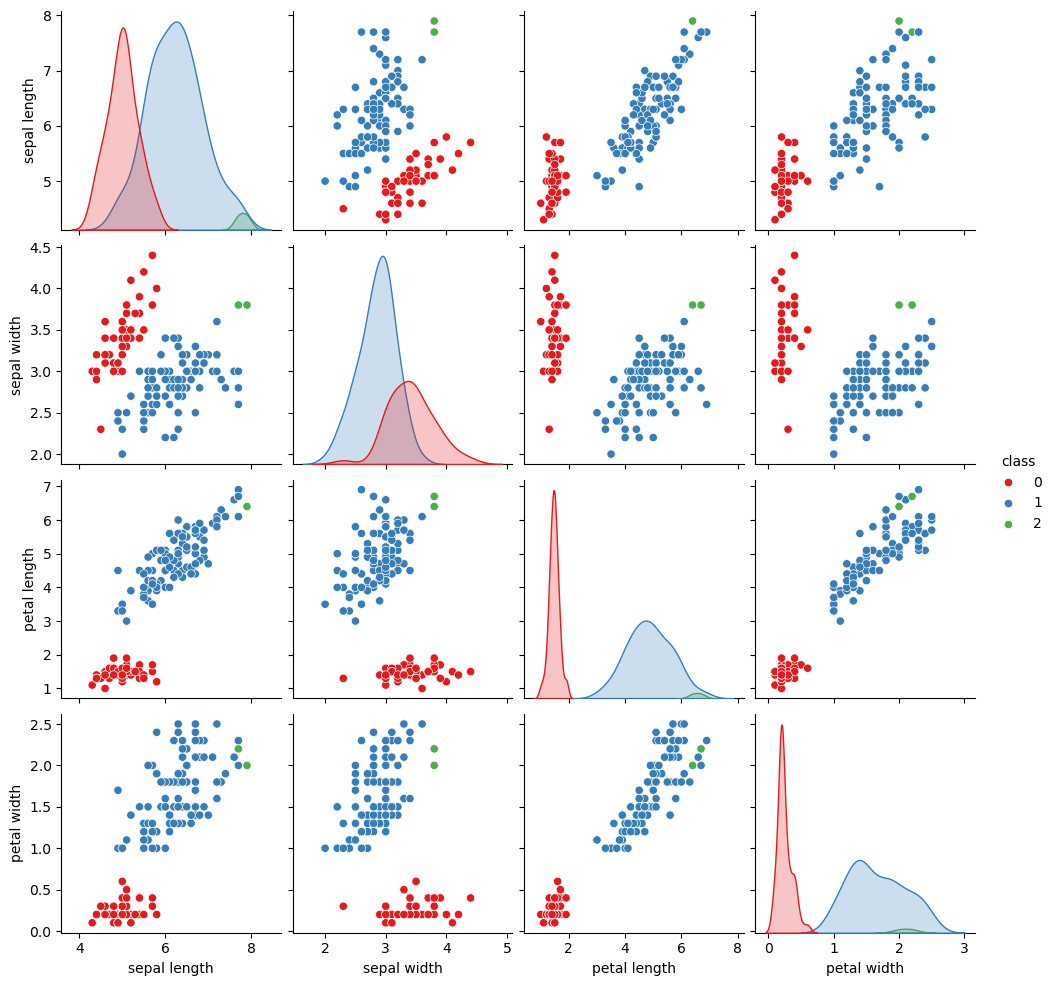

In [100]:
sns.pairplot(df_jerarquico, hue="class", palette="Set1")

In [105]:
coeficiente_silueta(X.to_numpy(), kmedias[1])

np.float64(0.5522757621586931)

In [106]:
coeficiente_silueta(X.to_numpy(), jerarquico)

np.float64(0.5116553400833247)